In [1]:
"""

hanze_qtl_workshop.ipynb

This script is for the Hanze QTL workshop
authors: Roy Oelen

"""


'\n\nhanze_qtl_workshop.ipynb\n\nThis script is for the Hanze QTL workshop\nauthors: Roy Oelen\n\n'

In [2]:
# we'll need these libraries
import pandas as pd
import seaborn as sbs
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests


In [3]:
# we need to upload files if we are using colab
from google.colab import files
uploaded = files.upload()


Saving CeD_genotypes_adjusted27082018_chr6.txt to CeD_genotypes_adjusted27082018_chr6.txt
Saving eqtlgen_fdr005_chr6.tsv.gz to eqtlgen_fdr005_chr6.tsv.gz
Saving gene_locations.txt to gene_locations.txt
Saving geuvadis_normalised_gene_expression_adjusted27082018_chr6.txt to geuvadis_normalised_gene_expression_adjusted27082018_chr6.txt
Saving snp_locations_CeD_adjusted27082018_chr6.tsv.gz to snp_locations_CeD_adjusted27082018_chr6.tsv.gz


In [4]:
# the locations of our files
genotypes_loc = 'CeD_genotypes_adjusted27082018_chr6.txt'
expression_loc = 'geuvadis_normalised_gene_expression_adjusted27082018_chr6.txt'
variant_positions_loc = 'snp_locations_CeD_adjusted27082018_chr6.tsv.gz'
gene_positions_loc = 'gene_locations.txt'
# and let's load these
genotypes = pd.read_csv(genotypes_loc, sep = '\t', header = 0, index_col = 0)
expression = pd.read_csv(expression_loc, sep = '\t', header = 0, index_col = 0)
variant_positions = pd.read_csv(variant_positions_loc, sep = '\t', header = 0)
gene_positions = pd.read_csv(gene_positions_loc, sep = '\t', header = 0)


In [5]:
# we'll make sure the samples are present in both tables, and order them the same

# get which samples are in both
samples_both = genotypes.columns.intersection(expression.columns)
# and subset in that order for both tables
genotypes_aligned = genotypes[samples_both]
expression_aligned = expression[samples_both]


In [6]:
# we'll use a simple correlation to check if the first variant, and the first gene are correlated

# extract first gene first variant, the first row of each dataframe
first_variant = genotypes_aligned.iloc[0]
first_gene = expression_aligned.iloc[0]

# calculate the correlation and accompanying p value
first_correlation, first_p_value = spearmanr(first_variant, first_gene)

# print the result
print(''.join(['correlation of first gene to first variant:', str(first_correlation)]))
print(''.join(['p of first gene to first variant:', str(first_p_value)]))

# that is not going to look that great

correlation of first gene to first variant:-0.020026719923540236
p of first gene to first variant:0.6998516803902854


In [7]:
# maybe we are just not testing enough, let's try to just do each variant against each gene

# we'll save the results in a list first
results = []

# check each variant
for variant in genotypes_aligned.index:
  # check each gene
  for feature in expression_aligned.index:
    # extract genotype and expression
    row_genotype = genotypes_aligned.loc[variant]
    row_expression = expression_aligned.loc[feature]
    # calculate stats
    correlation, p_value = spearmanr(row_genotype, row_expression)
    # put in a list
    results.append([variant, feature, correlation, p_value])

# put it all together
results_nowindow = pd.DataFrame(results, columns=['variant', 'feature', 'correlation', 'p_value'])


In [8]:
# let's see if we found anything this time
results_nowindow[results_nowindow['p_value'] < 0.05]


,variant,feature,correlation,p_value
82,rs1050976,ENSG00000123500,-0.166936,1.212220e-03
173,rs1050976,ENSG00000166278,-0.113414,2.851704e-02
186,rs1050976,ENSG00000172426,0.119034,2.148287e-02
193,rs1050976,ENSG00000178233,0.103063,4.669140e-02
214,rs1050976,ENSG00000188112,0.108436,3.631421e-02
...,...,...,...,...
15753,rs9273493,ENSG00000229921,-0.104764,4.316480e-02
15759,rs9273493,ENSG00000231628,0.122577,1.786816e-02
15800,rs9273493,ENSG00000243753,-0.104574,4.354726e-02
15814,rs9273493,ENSG00000261211,0.110558,3.279352e-02


In [9]:
# wow, 69 effects. That is not entirely fair though, right? We should apply multiple testing correction

# get a bonferroni one
_, p_bonferroni, _, _ = multipletests(results_nowindow['p_value'], method='bonferroni')
results_nowindow['p_bonferroni'] = p_bonferroni

# and BH
_, p_bh, _, _ = multipletests(results_nowindow['p_value'], method='fdr_bh')
results_nowindow['p_bh'] = p_bh


In [10]:
# let's see how much is left with Bonferroni
results_nowindow[results_nowindow['p_bonferroni'] < 0.05]
# not great

,variant,feature,correlation,p_value,p_bonferroni,p_bh
743,rs3734523,ENSG00000204644,-0.288242,1.436681e-08,2.272829e-04,6.493798e-06
1336,rs114816793,ENSG00000243753,-0.291598,9.581834e-09,1.515846e-04,4.593473e-06
1650,rs116392568,ENSG00000206341,-0.244501,1.761976e-06,2.787447e-02,6.636778e-04
1714,rs116392568,ENSG00000225851,-0.333383,3.920844e-11,6.202775e-07,2.297324e-08
1767,rs116392568,ENSG00000235290,-0.369918,1.537398e-13,2.432164e-09,1.013402e-10
1788,rs116392568,ENSG00000243753,-0.473527,3.043607e-22,4.814987e-18,4.012489e-19
2166,rs116168013,ENSG00000225851,-0.287011,1.664633e-08,2.633449e-04,7.315137e-06
2219,rs116168013,ENSG00000235290,-0.308243,1.187667e-09,1.878890e-05,6.478931e-07
2240,rs116168013,ENSG00000243753,-0.343037,9.715400e-12,1.536976e-07,5.911447e-09
2933,rs114676850,ENSG00000196126,-0.300681,3.117385e-09,4.931703e-05,1.590872e-06


In [11]:
# let's see how much is left with B&H instead
results_nowindow[results_nowindow['p_bh'] < 0.05]
# okay that is at least a bit more

,variant,feature,correlation,p_value,p_bonferroni,p_bh
743,rs3734523,ENSG00000204644,-0.288242,1.436681e-08,2.272829e-04,6.493798e-06
1130,rs114816793,ENSG00000196735,0.190593,2.133956e-04,1.000000e+00,4.185650e-02
1262,rs114816793,ENSG00000225851,-0.231156,6.464104e-06,1.022621e-01,2.130461e-03
1336,rs114816793,ENSG00000243753,-0.291598,9.581834e-09,1.515846e-04,4.593473e-06
1560,rs116392568,ENSG00000185250,0.198295,1.156316e-04,1.000000e+00,2.674135e-02
...,...,...,...,...,...,...
7212,rs74942078,ENSG00000243753,0.206077,6.077806e-05,9.615090e-01,1.526205e-02
7350,rs115199957,ENSG00000137177,-0.193994,1.632871e-04,1.000000e+00,3.587781e-02
7613,rs115199957,ENSG00000229390,-0.230859,6.647763e-06,1.051676e-01,2.146278e-03
15366,rs4320356,ENSG00000026950,0.524480,9.509171e-28,1.504351e-23,2.149073e-24


In [12]:
# a previous study has show some eQTL effects. Let's see if we can replicate those then. First we need to load the data

# the location of this data
eqtlgen_confinement_loc = 'eqtlgen_fdr005_chr6.tsv.gz'
# read this data
eqtlgen_confinement = pd.read_csv(eqtlgen_confinement_loc, sep = '\t', header = 0)
# give it column names we like
# subset to just variant and feature
eqtlgen_confinement = eqtlgen_confinement[['SNP', 'Gene']]
# rename the columns to be the same as our output
eqtlgen_confinement = eqtlgen_confinement.rename({'SNP' : 'variant', 'Gene' : 'feature'}, axis = 1)
eqtlgen_confinement

,variant,feature
0,rs2395943,ENSG00000124587
1,rs2296804,ENSG00000124587
2,rs2296805,ENSG00000124587
3,rs6458314,ENSG00000124587
4,rs9471975,ENSG00000124587
...,...,...
1235846,rs2982571,ENSG00000120262
1235847,rs115634162,ENSG00000198502
1235848,rs114519542,ENSG00000241106
1235849,rs74595026,ENSG00000180537


In [13]:
# we already tested everything, so we can subset our results to what is in our confinement
results_eqtlgen = results_nowindow.merge(eqtlgen_confinement, on=['variant', 'feature'])
results_eqtlgen
# seems that based on B&H, we could replicate four of them


,variant,feature,correlation,p_value,p_bonferroni,p_bh
0,rs3734523,ENSG00000124564,0.012477,8.102046e-01,1.000000e+00,9.911116e-01
1,rs3734523,ENSG00000124693,0.035631,4.926754e-01,1.000000e+00,9.462792e-01
2,rs3734523,ENSG00000158373,0.022913,6.591503e-01,1.000000e+00,9.711451e-01
3,rs3734523,ENSG00000158406,-0.010332,8.423502e-01,1.000000e+00,9.920783e-01
4,rs3734523,ENSG00000168405,-0.094758,6.754163e-02,1.000000e+00,7.676068e-01
...,...,...,...,...,...,...
236,rs9273493,ENSG00000231852,-0.010749,8.360794e-01,1.000000e+00,9.920783e-01
237,rs9273493,ENSG00000232629,-0.020654,6.909316e-01,1.000000e+00,9.778116e-01
238,rs9273493,ENSG00000234515,0.005654,9.133376e-01,1.000000e+00,9.966120e-01
239,rs9273493,ENSG00000237541,-0.061371,2.370420e-01,1.000000e+00,8.957076e-01


In [14]:
# if we would have only tried to replicate, we'd only have to correct for those
_, p_bonferroni_eqtlgen, _, _ = multipletests(results_eqtlgen['p_value'], method='bonferroni')
results_eqtlgen['p_bonferroni'] = p_bonferroni_eqtlgen
_, p_bh_eqtlgen, _, _ = multipletests(results_eqtlgen['p_value'], method='fdr_bh')
results_eqtlgen['p_bh'] = p_bh_eqtlgen
# let's see how many we would replicate then
results_eqtlgen
# which seems it is all of them


,variant,feature,correlation,p_value,p_bonferroni,p_bh
0,rs3734523,ENSG00000124564,0.012477,8.102046e-01,1.000000e+00,9.124266e-01
1,rs3734523,ENSG00000124693,0.035631,4.926754e-01,1.000000e+00,7.048119e-01
2,rs3734523,ENSG00000158373,0.022913,6.591503e-01,1.000000e+00,8.317027e-01
3,rs3734523,ENSG00000158406,-0.010332,8.423502e-01,1.000000e+00,9.227564e-01
4,rs3734523,ENSG00000168405,-0.094758,6.754163e-02,1.000000e+00,1.915004e-01
...,...,...,...,...,...,...
236,rs9273493,ENSG00000231852,-0.010749,8.360794e-01,1.000000e+00,9.200691e-01
237,rs9273493,ENSG00000232629,-0.020654,6.909316e-01,1.000000e+00,8.469723e-01
238,rs9273493,ENSG00000234515,0.005654,9.133376e-01,1.000000e+00,9.528760e-01
239,rs9273493,ENSG00000237541,-0.061371,2.370420e-01,1.000000e+00,4.555078e-01


In [15]:
# it would be great if we have some extra information. let's see what we have for the snps
variant_positions

,snpid,chr,pos
0,rs1050976,chr6,408079
1,rs3734523,chr6,25925987
2,rs114816793,chr6,31266090
3,rs116392568,chr6,31274380
4,rs116168013,chr6,31274555
5,rs2442719,chr6,31320538
6,rs114676850,chr6,32208324
7,rs116474664,chr6,32373698
8,rs115736223,chr6,32408527
9,rs115013759,chr6,32413545


In [16]:
# and what we have for the genes
gene_positions

,geneid,chr,left,right
0,ENSG00000223972,chr1,11869,14412
1,ENSG00000227232,chr1,14363,29806
2,ENSG00000243485,chr1,29554,31109
3,ENSG00000221311,chr1,30366,30503
4,ENSG00000237613,chr1,34554,36081
...,...,...,...,...
53929,ENSG00000198695,chrM,14149,14673
53930,ENSG00000210194,chrM,14674,14742
53931,ENSG00000198727,chrM,14747,15887
53932,ENSG00000210195,chrM,15888,15953


In [17]:
# let's rename the columns to make them both unique and matching where needed
variant_positions = variant_positions.rename({'snpid' : 'variant', 'chr' : 'var_chr', 'pos' : 'var_pos'}, axis = 1)
gene_positions = gene_positions.rename({'geneid' : 'feature', 'chr' : 'feature_chr', 'left' : 'feature_start', 'right' : 'feature_end'}, axis = 1)

# and add them to the output
results_nowindow = results_nowindow.merge(variant_positions, how = 'left', on = 'variant')
results_nowindow = results_nowindow.merge(gene_positions, how = 'left', on = 'feature')

# and let's see what they look like
results_nowindow


,variant,feature,correlation,p_value,p_bonferroni,p_bh,var_chr,var_pos,feature_chr,feature_start,feature_end
0,rs1050976,ENSG00000004809,-0.020027,6.998517e-01,1.000000e+00,9.801393e-01,chr6,408079,chr6,110745890,110797844
1,rs1050976,ENSG00000007866,-0.054060,2.977213e-01,1.000000e+00,9.121168e-01,chr6,408079,chr6,35441374,35464861
2,rs1050976,ENSG00000010030,-0.084734,1.022713e-01,1.000000e+00,8.311051e-01,chr6,408079,chr6,36322419,36356164
3,rs1050976,ENSG00000010810,-0.055296,2.868009e-01,1.000000e+00,9.087410e-01,chr6,408079,chr6,111981535,112194655
4,rs1050976,ENSG00000010818,-0.035447,4.949124e-01,1.000000e+00,9.462792e-01,chr6,408079,chr6,143072604,143266338
...,...,...,...,...,...,...,...,...,...,...,...
15815,rs9273493,ENSG00000261353,0.034223,5.099377e-01,1.000000e+00,9.479092e-01,chr6,32628247,chr6,26527291,26527632
15816,rs9273493,ENSG00000261366,0.021463,6.794805e-01,1.000000e+00,9.744285e-01,chr6,32628247,chr6,96023059,96025326
15817,rs9273493,ENSG00000261584,0.032989,5.253284e-01,1.000000e+00,9.519748e-01,chr6,32628247,chr6,26686469,26688192
15818,rs9273493,ENSG00000026950,-0.021191,6.833151e-01,1.000000e+00,9.748120e-01,chr6,32628247,chr6,26402465,26415444


In [18]:
# we can also test less, by looking at variants close to genes. let's see how far the variants are from the flanks of the genes
results_nowindow['variant_to_start'] = results_nowindow['feature_start'] - results_nowindow['var_pos']
results_nowindow['variant_to_end'] = results_nowindow['feature_end'] - results_nowindow['var_pos']
results_nowindow

,variant,feature,correlation,p_value,p_bonferroni,p_bh,var_chr,var_pos,feature_chr,feature_start,feature_end,variant_to_start,variant_to_end
0,rs1050976,ENSG00000004809,-0.020027,6.998517e-01,1.000000e+00,9.801393e-01,chr6,408079,chr6,110745890,110797844,110337811,110389765
1,rs1050976,ENSG00000007866,-0.054060,2.977213e-01,1.000000e+00,9.121168e-01,chr6,408079,chr6,35441374,35464861,35033295,35056782
2,rs1050976,ENSG00000010030,-0.084734,1.022713e-01,1.000000e+00,8.311051e-01,chr6,408079,chr6,36322419,36356164,35914340,35948085
3,rs1050976,ENSG00000010810,-0.055296,2.868009e-01,1.000000e+00,9.087410e-01,chr6,408079,chr6,111981535,112194655,111573456,111786576
4,rs1050976,ENSG00000010818,-0.035447,4.949124e-01,1.000000e+00,9.462792e-01,chr6,408079,chr6,143072604,143266338,142664525,142858259
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15815,rs9273493,ENSG00000261353,0.034223,5.099377e-01,1.000000e+00,9.479092e-01,chr6,32628247,chr6,26527291,26527632,-6100956,-6100615
15816,rs9273493,ENSG00000261366,0.021463,6.794805e-01,1.000000e+00,9.744285e-01,chr6,32628247,chr6,96023059,96025326,63394812,63397079
15817,rs9273493,ENSG00000261584,0.032989,5.253284e-01,1.000000e+00,9.519748e-01,chr6,32628247,chr6,26686469,26688192,-5941778,-5940055
15818,rs9273493,ENSG00000026950,-0.021191,6.833151e-01,1.000000e+00,9.748120e-01,chr6,32628247,chr6,26402465,26415444,-6225782,-6212803


In [19]:
# if we confine ourselves to variants at most 50k away from the gene, we should have lest tests
results_50kwindow = results_nowindow[((results_nowindow['variant_to_start'] > -50000) & (results_nowindow['variant_to_start'] < 50000)) | ((results_nowindow['variant_to_end'] > -50000) & (results_nowindow['variant_to_end'] < 50000))].copy()
# if we would have only tried in this window, we'd only have to correct for those
_, p_bonferroni_50k, _, _ = multipletests(results_50kwindow['p_value'], method='bonferroni')
results_50kwindow['p_bonferroni'] = p_bonferroni_50k
_, p_bh_50k, _, _ = multipletests(results_50kwindow['p_value'], method='fdr_bh')
results_50kwindow['p_bh'] = p_bh_50k

# so let's see what we have
results_50kwindow


,variant,feature,correlation,p_value,p_bonferroni,p_bh,var_chr,var_pos,feature_chr,feature_start,feature_end,variant_to_start,variant_to_end
539,rs3734523,ENSG00000124564,0.012477,8.102046e-01,1.000000e+00,9.317353e-01,chr6,25925987,chr6,25833294,25882514,-92693,-43473
1276,rs114816793,ENSG00000227939,0.072136,1.644311e-01,1.000000e+00,3.415616e-01,chr6,31266090,chr6,31248094,31249296,-17996,-16794
1728,rs116392568,ENSG00000227939,0.074885,1.488937e-01,1.000000e+00,3.415616e-01,chr6,31274380,chr6,31248094,31249296,-26286,-25084
2180,rs116168013,ENSG00000227939,0.089956,8.273671e-02,1.000000e+00,2.927607e-01,chr6,31274555,chr6,31248094,31249296,-26461,-25259
2506,rs2442719,ENSG00000199332,0.079842,1.237357e-01,1.000000e+00,3.227339e-01,chr6,31320538,chr6,31369929,31370027,49391,49489
2614,rs2442719,ENSG00000225059,-0.003590,9.449137e-01,1.000000e+00,9.659118e-01,chr6,31320538,chr6,31351824,31352193,31286,31655
2618,rs2442719,ENSG00000225851,-0.103443,4.588376e-02,1.000000e+00,1.918775e-01,chr6,31320538,chr6,31349851,31350065,29313,29527
2979,rs114676850,ENSG00000204301,-0.037894,4.655923e-01,1.000000e+00,6.697598e-01,chr6,32208324,chr6,32162620,32191844,-45704,-16480
3430,rs116474664,ENSG00000204287,-0.007524,8.848452e-01,1.000000e+00,9.659118e-01,chr6,32373698,chr6,32407619,32412823,33921,39125
3882,rs115736223,ENSG00000204287,0.019019,7.142703e-01,1.000000e+00,9.317353e-01,chr6,32408527,chr6,32407619,32412823,-908,4296


In [22]:
# let's sort by significance
results_50kwindow = results_50kwindow.sort_values(by = 'p_value')
results_50kwindow


,variant,feature,correlation,p_value,p_bonferroni,p_bh,var_chr,var_pos,feature_chr,feature_start,feature_end,variant_to_start,variant_to_end
15366,rs4320356,ENSG00000026950,0.524480,9.509171e-28,4.374218e-26,4.374218e-26,chr6,26423560,chr6,26402465,26415444,-21095,-8116
15819,rs9273493,ENSG00000179344,0.521377,2.190196e-27,1.007490e-25,5.037451e-26,chr6,32628247,chr6,32627244,32636160,-1003,7913
7001,rs74942078,ENSG00000196126,-0.304037,2.038348e-09,9.376400e-08,3.125467e-08,chr6,32605884,chr6,32546546,32557625,-59338,-48259
5354,rs660895,ENSG00000229391,-0.295244,6.134169e-09,2.821718e-07,7.054295e-08,chr6,32577380,chr6,32520490,32527799,-56890,-49581
5650,rs532098,ENSG00000196735,0.289676,1.209127e-08,5.561983e-07,1.112397e-07,chr6,32578052,chr6,32595956,32614839,17904,36787
5198,rs660895,ENSG00000196735,0.239400,2.921884e-06,1.344067e-04,2.240111e-05,chr6,32577380,chr6,32595956,32614839,18576,37459
6554,rs111410428,ENSG00000196735,0.192381,1.854923e-04,8.532648e-03,1.218950e-03,chr6,32590953,chr6,32595956,32614839,5003,23886
6097,rs111421016,ENSG00000196126,-0.151335,3.391223e-03,1.559963e-01,1.949953e-02,chr6,32586854,chr6,32546546,32557625,-40308,-29229
6549,rs111410428,ENSG00000196126,0.144548,5.157675e-03,2.372531e-01,2.636145e-02,chr6,32590953,chr6,32546546,32557625,-44407,-33328
6102,rs111421016,ENSG00000196735,0.126749,1.430169e-02,6.578779e-01,6.578779e-02,chr6,32586854,chr6,32595956,32614839,9102,27985


<ipython-input-23-b251f2272fa2>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sbs.boxplot(x="rs4320356", y="ENSG00000026950", data=variant_to_gene,


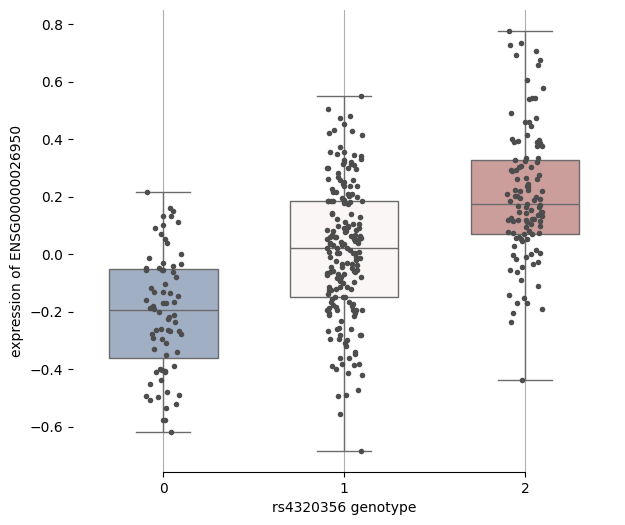

In [23]:
# finally, let's take a look at how these eQTLs seem in a plot

# extract the gene
expression_gene = expression.loc['ENSG00000026950']
# extract the genotype
genotype_variant = genotypes.loc['rs4320356']
# combine into one dataframe
variant_to_gene = pd.merge(genotype_variant, expression_gene, right_index = True, left_index = True)

# set the size of the plot
f, ax = plt.subplots(figsize=(7, 6))

# now create the plot
sbs.boxplot(x="rs4320356", y="ENSG00000026950", data=variant_to_gene,
            whis=[0, 100], width=.6, palette="vlag")

# Add in points to show each observation
sbs.stripplot(x="rs4320356", y="ENSG00000026950", data=variant_to_gene,
              size=4, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="expression of ENSG00000026950")
ax.set(xlabel="rs4320356 genotype")
sbs.despine(trim=True, left=True)
